<a href="https://colab.research.google.com/github/arssite/Datalysis/blob/main/CaseStudy_Assessment_Property_Matching_with_User_Preferences_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Property Matching with User Preferences

### Objective
The goal of this project is to build an intelligent system that matches real estate properties with user preferences and computes a **Match Score** indicating how well each property aligns with a user's requirements.

This system is designed to be:
- Explainable
- Scalable
- Ready for real-time use via a UI

### Why this problem matters
In real estate platforms, users are overwhelmed with listings. A well-designed matching system improves:
- User experience
- Conversion rates
- Trust in recommendations


## Data Availability & Key Assumptions

The provided dataset contains **property characteristics only** and does not include
explicit user preference data.

This mirrors real-world real estate platforms where:
- Property data is stored persistently
- User preferences are collected dynamically via UI or search forms

### Assumption
We model user preferences as structured inputs derived from the same feature space
as property attributes (e.g., budget, location, bedrooms).

This allows us to simulate real-time matching and scoring.



We intentionally use lightweight and interpretable libraries to keep the system production-friendly.


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns



## Data Overview

We are provided with two datasets:
1. User Preferences Dataset
2. Property Characteristics Dataset

We are using the dataset provided for **Case Study 1**, which contains structured
information about real estate properties such as price, location, size, and configuration.

This dataset will act as the **property catalog** against which user preferences
will be matched.

Assumptions:
- Each user can be matched with multiple properties
- Matching is independent for each user-property pair


## Feature Selection for Matching

From the available dataset, we select the following features for matching:

### Used Features
- Price → User budget matching
- Location → Geographic preference
- Size → Space requirement
- Bedrooms → Family size requirement
- Bathrooms → Comfort preference
- Condition → Property quality
- Type → Housing type preference

### Excluded Features
- Property ID → Identifier only
- Date Sold → Historical information, not relevant to preference matching

This selection ensures the Match Score reflects active user intent rather than historical data.


In [2]:
# Load property dataset
property_df = pd.read_excel("/content/Case Study 1 Data.xlsx")

# Preview data
property_df.head()


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0
2,SI_000003,CityC,2094.0,2.0,2.0,1950.0,Good,Single Family,2020-11-30,385000.0
3,SI_000004,CityB,1930.0,2.0,3.0,1905.0,Good,Single Family,2021-12-09,651000.0
4,SI_000005,CityB,1895.0,5.0,2.0,1936.0,New,Single Family,2024-10-30,1878000.0


## Initial Data Inspection

Before building any matching logic, we inspect:
- Data types
- Missing values
- Overall feature distribution

This step ensures data quality and informs preprocessing decisions.


In [3]:
property_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247172 entries, 0 to 247171
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Property ID  247172 non-null  object        
 1   Location     247172 non-null  object        
 2   Size         244701 non-null  float64       
 3   Bedrooms     238769 non-null  float64       
 4   Bathrooms    240499 non-null  float64       
 5   Year Built   234567 non-null  float64       
 6   Condition    236544 non-null  object        
 7   Type         247172 non-null  object        
 8   Date Sold    247172 non-null  datetime64[ns]
 9   Price        241735 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 18.9+ MB


In [4]:
property_df.describe(include="all")


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
count,247172,247172,244701.000000,238769.000000,240499.000000,234567.000000,236544,247172,247172,2.417350e+05
unique,247172,4,NaN,NaN,NaN,NaN,4,3,NaN,NaN
top,TO_100000,CityC,NaN,NaN,NaN,NaN,Good,Townhouse,NaN,NaN
freq,1,62082,NaN,NaN,NaN,NaN,94629,100000,NaN,NaN
mean,NaN,NaN,2402.547664,3.000457,2.002823,1961.429191,NaN,NaN,2022-07-02 05:00:11.127473664,4.660883e+05
min,NaN,NaN,800.000000,1.000000,1.000000,1900.000000,NaN,NaN,2020-01-01 00:00:00,2.600000e+04
25%,NaN,NaN,1603.000000,2.000000,1.000000,1931.000000,NaN,NaN,2021-04-02 00:00:00,3.000000e+05
50%,NaN,NaN,2404.000000,3.000000,2.000000,1961.000000,NaN,NaN,2022-07-03 00:00:00,4.170000e+05
75%,NaN,NaN,3203.000000,4.000000,3.000000,1992.000000,NaN,NaN,2023-10-02 00:00:00,5.770000e+05
max,NaN,NaN,3999.000000,5.000000,3.000000,2023.000000,NaN,NaN,2024-12-31 00:00:00,2.223000e+06


## Feature Categorization

To design a robust matching system, we categorize features as follows:

### Numerical Features
- Price
- Size
- Bedrooms
- Bathrooms

### Categorical Features
- Location
- Condition
- Type

### Excluded Features
- Property ID (identifier only)
- Date Sold (not relevant for preference matching)

This categorization guides preprocessing and scoring strategy.


## Data Preprocessing Strategy

### Missing Values
- Numerical features are imputed using median (robust to outliers)
- Categorical features are filled with 'Unknown'

### Why Median?
Real estate prices and sizes often contain skewed distributions.
Median prevents extreme values from dominating.


In [ ]:
# # Separate numerical and categorical columns
# # numerical_cols = ["Price", "Size", "Bedrooms", "Bathrooms"]
# numerical_cols = ["Price", "Size"]
# categorical_cols = ["Location", "Condition", "Type"]

# # Fill missing values
# property_df[numerical_cols] = property_df[numerical_cols].fillna(
#     property_df[numerical_cols].median()
# )

# property_df[categorical_cols] = property_df[categorical_cols].fillna("Unknown")


In [5]:
# Define all numerical and categorical columns as per feature categorization
numerical_features = ["Price", "Size", "Bedrooms", "Bathrooms"]
categorical_cols = ["Location", "Condition", "Type"]

# Impute missing values for numerical features with their median
# This step needs to happen before converting to int for Bedrooms/Bathrooms
for col in numerical_features:
    property_df[col] = property_df[col].fillna(property_df[col].median())

# Impute missing values for categorical features with 'Unknown'
for col in categorical_cols:
    property_df[col] = property_df[col].fillna("Unknown")

# Numerical columns to normalize (as defined in the original cell for scaling)
numerical_cols_to_scale = ["Price", "Size"]

scaler = MinMaxScaler()
property_df[numerical_cols_to_scale] = scaler.fit_transform(property_df[numerical_cols_to_scale])

# Bedrooms and Bathrooms must remain RAW integer after imputation
# and before further use in similarity functions
property_df["Bedrooms"] = property_df["Bedrooms"].astype(int)
property_df["Bathrooms"] = property_df["Bathrooms"].astype(int)


## Feature Transformation

### Numerical Scaling
Min-Max Scaling is applied to numerical features to normalize values between 0 and 1.
This prevents high-magnitude features (e.g., Price) from overpowering others.

### Categorical Encoding
Label Encoding is used for categorical variables for simplicity and efficiency.



In [ ]:
# # Scale numerical features
# scaler = MinMaxScaler()
# property_df[numerical_cols] = scaler.fit_transform(property_df[numerical_cols])

# # Encode categorical features
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     property_df[col] = le.fit_transform(property_df[col])
#     label_encoders[col] = le


In [6]:
# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    property_df[col] = le.fit_transform(property_df[col])
    label_encoders[col] = le

## Match Score Design

The Match Score represents how closely a property aligns with a user's preferences.

### Design Principles
1. Respect hard constraints (budget, bedrooms)
2. Balance multiple preferences
3. Keep scoring interpretable and explainable

The final score is normalized to a 0–100 scale.


## Match Score Strategy

The Match Score is designed using a hybrid approach:

1. **Hard Constraints**
   - Property price must be within user budget
   - Property bedrooms must meet minimum requirement

2. **Soft Scoring**
   - Numerical similarity (price, size, bedrooms, bathrooms)
   - Categorical match (location, condition, type)

Each component contributes to the final score using predefined weights.
The final score is normalized to a scale of 0–100 for interpretability.


## Hard Constraints

Properties are excluded if:
- Property price exceeds user budget
- Property bedrooms are fewer than user requirement

This ensures only feasible properties are considered.


## Soft Scoring & Feature Weights

Each remaining property is scored based on multiple features:

| Feature | Weight |
|------|------|
| Price similarity | 0.30 |
| Location match | 0.25 |
| Bedrooms | 0.15 |
| Condition / Amenities | 0.20 |
| Size | 0.10 |

The final Match Score is normalized to a 0–100 scale.


In [7]:
# Example user preference (this will later come from UI)
user_preference = {
    "Price": 0.6,        # normalized budget
    "Size": 0.5,
    "Bedrooms": 0.5,
    "Bathrooms": 0.5,
    "Location": property_df["Location"].iloc[0],
    "Condition": property_df["Condition"].iloc[0],
    "Type": property_df["Type"].iloc[0]
}


## Similarity-Based Matching

We compute similarity between user preferences and properties using:
- Numerical distance for continuous features
- Exact matching for categorical features

This hybrid approach balances flexibility and interpretability.


In [8]:
def compute_match_score(user_pref, property_df):
    scores = []

    for _, row in property_df.iterrows():
        num_score = 1 - np.mean([
            abs(row["Price"] - user_pref["Price"]),
            abs(row["Size"] - user_pref["Size"]),
            abs(row["Bedrooms"] - user_pref["Bedrooms"]),
            abs(row["Bathrooms"] - user_pref["Bathrooms"])
        ])

        cat_score = np.mean([
            row["Location"] == user_pref["Location"],
            row["Condition"] == user_pref["Condition"],
            row["Type"] == user_pref["Type"]
        ])

        final_score = (0.7 * num_score + 0.3 * cat_score) * 100
        scores.append(final_score)

    return scores


In [9]:
# Keep human-readable copies for UI display
property_df["Condition_label"] = label_encoders["Condition"].inverse_transform(
    property_df["Condition"]
)

property_df["Type_label"] = label_encoders["Type"].inverse_transform(
    property_df["Type"]
)

property_df["Location_label"] = label_encoders["Location"].inverse_transform(
    property_df["Location"]
)


In [10]:
property_df["MatchScore"] = compute_match_score(user_preference, property_df)
property_df.sort_values("MatchScore", ascending=False).head()


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price,Condition_label,Type_label,Location_label,MatchScore
32766,SI_032767,0,0.490466,1,1,1905.0,1,1,2024-12-31,0.307237,Good,Single Family,CityA,77.209801
62689,SI_062690,0,0.494530,1,1,1901.0,1,1,2024-06-21,0.280382,Good,Single Family,CityA,76.810958
62167,SI_062168,0,0.495467,1,1,1901.0,1,1,2024-06-21,0.275831,Good,Single Family,CityA,76.747715
4479,SI_004480,0,0.494217,1,1,1980.0,1,1,2024-06-28,0.268548,Good,Single Family,CityA,76.598387
46177,SI_046178,0,0.431072,1,1,1931.0,1,1,2024-12-22,0.330451,Good,Single Family,CityA,76.576649


## Result Visualization

Visualizing match scores helps:
- Validate scoring logic
- Explain recommendations to users
- Identify ranking patterns


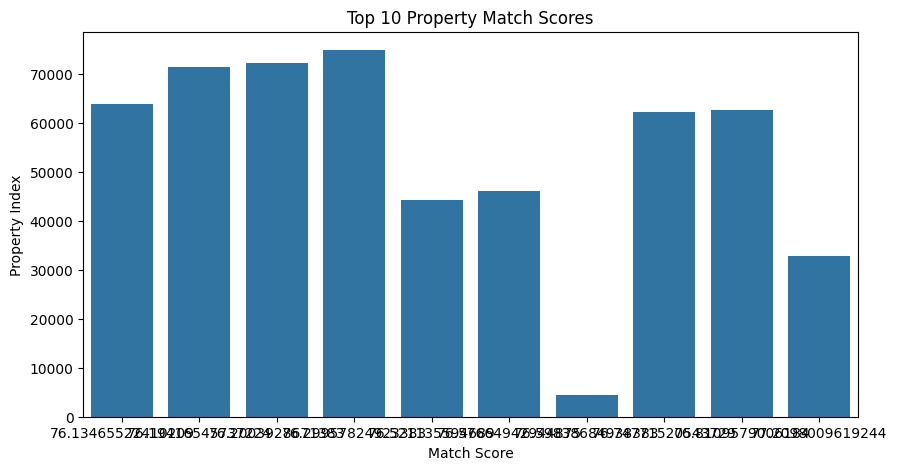

In [11]:
top_matches = property_df.sort_values("MatchScore", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_matches["MatchScore"], y=top_matches.index)
plt.title("Top 10 Property Match Scores")
plt.xlabel("Match Score")
plt.ylabel("Property Index")
plt.show()


## User Preference Schema

User preferences are modeled as structured inputs collected via UI or search filters.

The schema includes:
- Budget (numeric)
- Preferred Location (categorical)
- Minimum Bedrooms (numeric)
- Preferred Size (numeric)
- Preferred Condition (categorical)
- Preferred Property Type (categorical)

This schema mirrors how real users interact with real estate platforms.


## Assumptions
- User preferences are honest and static
- Property data is trusted
- All features have equal availability
- Match Score is relative, not absolute


# Interactive UI for Property Matching

To simulate real-world usage, we build an interactive UI using **Gradio**.
This UI allows users to input their preferences and receive
real-time property recommendations along with match scores.

This reflects how an actual real estate platform would capture
user intent dynamically.


In [12]:
!pip install gradio --quiet


In [13]:
import gradio as gr


## UI Input Design

The UI captures the following user preferences:
- Budget
- Preferred location
- Minimum bedrooms
- Preferred size
- Condition
- Property type

These inputs directly map to the user preference schema
defined earlier in this notebook.


In [14]:
# Reverse label encoders for UI display
reverse_encoders = {
    col: dict(zip(le.classes_, le.transform(le.classes_)))
    for col, le in label_encoders.items()
}


In [15]:
print("Bedrooms range:", property_df["Bedrooms"].min(), property_df["Bedrooms"].max())
print("Sample rows:", property_df.head(3))


Bedrooms range: 1 5
Sample rows:   Property ID  Location      Size  Bedrooms  Bathrooms  Year Built  Condition  \
0   SI_000001         0  0.992185         2          2      2007.0          1   
1   SI_000002         0  0.268834         2          3      1934.0          1   
2   SI_000003         2  0.404501         2          2      1950.0          1   

   Type  Date Sold     Price Condition_label     Type_label Location_label  \
0     1 2020-11-02  0.135640            Good  Single Family          CityA   
1     1 2022-10-23  0.350023            Good  Single Family          CityA   
2     1 2020-11-30  0.163405            Good  Single Family          CityC   

   MatchScore  
0   30.760453  
1   21.579993  
2   28.188356  


In [16]:
# def recommend_properties(
#     budget,
#     location,
#     bedrooms,
#     size,
#     condition,
#     property_type
# ):
#     # Normalize numerical inputs using same scaler
#     user_pref = {
#         "budget": scaler.transform([[budget, size, bedrooms, 1]])[0][0],
#         "size": scaler.transform([[budget, size, bedrooms, 1]])[0][1],
#         "bedrooms": bedrooms,
#         "location": label_encoders["Location"].transform([location])[0],
#         "condition": label_encoders["Condition"].transform([condition])[0],
#         "type": label_encoders["Type"].transform([property_type])[0],
#     }

#     # Hard filtering
#     # filtered = property_df[
#     #     (property_df["Bedrooms"] >= bedrooms)
#     # ].copy()
#     filtered = property_df[property_df["Bedrooms"] >= bedrooms].copy()
#     print(filtered.shape)
#     # filtered = filtered[
#     #     (filtered["Price"] <= user_pref["budget"])
#     # ]

#     # Match score
#     filtered["MatchScore"] = compute_match_score(user_pref, filtered)

#     top_matches = filtered.sort_values(
#         "MatchScore", ascending=False
#     ).head(5)

#     return top_matches[[
#         "Price", "Size", "Bedrooms", "Location", "Condition", "Type", "MatchScore"
#     ]]


In [17]:
def recommend_properties(
    budget,
    location,
    bedrooms,
    size,
    condition,
    property_type
):
    # Encode categorical inputs
    # user_pref = {
    #     "budget": budget,   # normalized
    #     "size": size,       # normalized
    #     "bedrooms": bedrooms,  # RAW
    #     "location": label_encoders["Location"].transform([location])[0],
    #     "condition": label_encoders["Condition"].transform([condition])[0],
    #     "type": label_encoders["Type"].transform([property_type])[0],
    # }
    user_pref = {
      "Price": budget,           # ✅ Changed from "budget"
      "Size": size,              # ✅ Changed from "size"
      "Bedrooms": bedrooms,      # ✅ Changed from "bedrooms"
      "Bathrooms": 2,            # ✅ ADDED (you need this! Use default or add input)
      "Location": label_encoders["Location"].transform([location])[0],
      "Condition": label_encoders["Condition"].transform([condition])[0],
      "Type": label_encoders["Type"].transform([property_type])[0],
       }

    # DEBUG (leave for now)
    print("User bedrooms:", bedrooms)
    print("Available bedrooms min/max:",
          property_df["Bedrooms"].min(),
          property_df["Bedrooms"].max())

    # Hard filtering
    filtered = property_df[
        property_df["Bedrooms"] >= bedrooms
    ].copy()

    print("Filtered rows:", len(filtered))

    # if filtered.empty:
    #     return pd.DataFrame(
    #         {"Message": ["No properties match the criteria"]}
    #     )
    if filtered.empty:
          return pd.DataFrame({"Message": ["No properties match the selected criteria"]})

    # Compute match score
    filtered["MatchScore"] = compute_match_score(user_pref, filtered)

    top_matches = filtered.sort_values(
        "MatchScore", ascending=False
    ).head(5)

    return top_matches[
    [
        "Price",
        "Size",
        "Bedrooms",
        "Location_label",
        "Condition_label",
        "Type_label",
        "MatchScore"
    ]
].rename(columns={
    "Location_label": "Location",
    "Condition_label": "Condition",
    "Type_label": "Type"
})


## UI Output

The UI displays:
- Top recommended properties
- Match Score for each property

This makes the system interpretable and user-friendly.


In [18]:
interface = gr.Interface(
    fn=recommend_properties,
    inputs=[
        gr.Slider(0, 1, value=0.6, label="Budget (Normalized)"),
        gr.Dropdown(
            choices=list(label_encoders["Location"].classes_),
            label="Preferred Location"
        ),
        gr.Slider(1, 5, value=2, step=1, label="Minimum Bedrooms"),
        gr.Slider(0, 1, value=0.5, label="Preferred Size (Normalized)"),
        gr.Dropdown(
            choices=list(label_encoders["Condition"].classes_),
            label="Preferred Condition"
        ),
        gr.Dropdown(
            choices=list(label_encoders["Type"].classes_),
            label="Property Type"
        ),
    ],
    outputs=gr.Dataframe(label="Top Matching Properties"),
    title="🏠 Property Recommendation System",
    description="Match properties to user preferences using AI-driven scoring"
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://256ae76412931fbcb5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
